# Prepping Data for Modeling


In [61]:
##kaggle animal shelter outcome
import subprocess
from sklearn.tree import DecisionTreeClassifier, export_graphviz 
from sklearn import tree
import pandas as pd
import numpy as np
from pandas import DataFrame, merge, read_table

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn import cross_validation
from pandas import read_table, DataFrame
from os import system

In [62]:
#load the data
animals_train = pd.read_csv('train.csv')
animals_test = pd.read_csv('test.csv')

In [63]:
#rows in training and test dataset
len(animals_train), len(animals_test)

(26729, 11456)

In [69]:
animals_train.head()

AnimalID     Name          DateTime      OutcomeType OutcomeSubtype  \
0  A671945  Hambone   2/12/2014 18:22  Return_to_owner            NaN   
1  A656520    Emily  10/13/2013 12:44       Euthanasia      Suffering   
2  A686464   Pearce   1/31/2015 12:28         Adoption         Foster   
3  A683430      NaN   7/11/2014 19:09         Transfer        Partner   
4  A667013      NaN  11/15/2013 12:52         Transfer        Partner   

  AnimalType SexuponOutcome AgeuponOutcome                        Breed  \
0        Dog  Neutered Male         1 year        Shetland Sheepdog Mix   
1        Cat  Spayed Female         1 year       Domestic Shorthair Mix   
2        Dog  Neutered Male        2 years                 Pit Bull Mix   
3        Cat    Intact Male        3 weeks       Domestic Shorthair Mix   
4        Dog  Neutered Male        2 years  Lhasa Apso/Miniature Poodle   

         Color  
0  Brown/White  
1  Cream Tabby  
2   Blue/White  
3   Blue Cream  
4          Tan

In [5]:
#combine train and test, but add additional column to denote which rows are from train which are from test
# animals_train['train']=1
# animals_test['train']=0

In [6]:
#name and outcomesubtype are irrelevant features, so they can be dropped
# animals_train.drop(["Name", "OutcomeSubtype"], axis=1, inplace=True)
# animals_test.drop(["Name"], axis=1, inplace=True)

#Separating IDs out. Store in train_id and test_id in case of future use
# train_id = animals_train[["AnimalID"]]
# test_id = animals_test[["ID"]]
# animals_train.drop(["AnimalID"], axis=1, inplace=True)
# animals_test.drop(["ID"], axis=1, inplace=True)

# #Store in train outcomes to an array variable, drop OutcomeType
train_outcome = animals_train["OutcomeType"]
# animals_train.drop(["OutcomeType"], axis=1, inplace=True)

In [7]:
# combined = pd.concat([animals_train,animals_test])

In [8]:
animals_train['SexuponOutcome']=animals_train[['SexuponOutcome']].fillna('Unknown')
animals_test['SexuponOutcome']=animals_test[['SexuponOutcome']].fillna('Unknown')

In [9]:
sexType = animals_train['SexuponOutcome'].unique()
print(sexType)

['Neutered Male' 'Spayed Female' 'Intact Male' 'Intact Female' 'Unknown']


In [10]:
# create a dict to use are a reference for creating new columns Sex, Neutered
M_F = {'Neutered Male':'Male','Spayed Female':'Female','Intact Male':'Male','Intact Female':'Female','Unknown':'Unknown'}
N_T = {'Neutered Male':'Neutered','Spayed Female':'Neutered','Intact Male':'Intact','Intact Female':'Intact','Unknown':'Unknown'}

animals_train['Sex'] = animals_train.SexuponOutcome.map(M_F)
animals_train['Neutered'] = animals_train.SexuponOutcome.map(N_T)


animals_test['Sex'] = animals_train.SexuponOutcome.map(M_F)
animals_test['Neutered'] = animals_train.SexuponOutcome.map(N_T)

In [11]:
#convert DateTime and add DateTimeIn as a new column
animals_train['DateTime']=pd.to_datetime(animals_train.DateTime, infer_datetime_format=True)   
animals_test['DateTime']=pd.to_datetime(animals_test.DateTime, infer_datetime_format=True)  

In [12]:
# converts or calculates age in terms of years
def calc_age_in_years(x):
    x=str(x)
    if x == 'nan': return 0
    age = int(x.split()[0])
    if x.find('year')> -1: return age
    if x.find('month')> -1: return age/12.
    if x.find('week')> -1: return age/52.
    if x.find('day')> -1: return age/365.
    else: return 0
    
animals_train['AgeOutInYears'] = animals_train.AgeuponOutcome.apply(calc_age_in_years)
animals_test['AgeOutInYears'] = animals_test.AgeuponOutcome.apply(calc_age_in_years)    

In [13]:
# convert all of the AgeuponOutcome values into weeks

def convert_AgeuponOutcome_to_weeks(df):
    result = {}
    for k in df['AgeuponOutcome'].unique():
        if type(k) != type(""):
            result[k] = -1
        else:
            v1, v2 = k.split()
            if v2 in ["year", "years"]:
                result[k] = int(v1) * 52
            elif v2 in ["month", "months"]:
                result[k] = int(v1) * 4.5
            elif v2 in ["week", "weeks"]:
                result[k] = int(v1)
            elif v2 in ["day", "days"]:
                result[k] = int(v1) / 7
                
    df['AgeOutInWeeks'] = df['AgeuponOutcome'].map(result).astype(float)
    #df = df.drop('AgeuponOutcome', axis = 1)
                
    return df

animals_train = convert_AgeuponOutcome_to_weeks(animals_train)
animals_test = convert_AgeuponOutcome_to_weeks(animals_test)


In [14]:
animals_train.AnimalType.unique(),animals_train.Sex.unique(),animals_train.Neutered.unique(),animals_train.Breed.unique()

(array(['Dog', 'Cat'], dtype=object),
 array(['Male', 'Female', 'Unknown'], dtype=object),
 array(['Neutered', 'Intact', 'Unknown'], dtype=object),
 array(['Shetland Sheepdog Mix', 'Domestic Shorthair Mix', 'Pit Bull Mix',
        ..., 'Vizsla/Boxer', 'German Shepherd/Australian Kelpie',
        'Boxer/German Shepherd'], dtype=object))

In [15]:
def get_sex(x):
    x=str(x)
    if x.find('Male') >= 0: return 'male'
    if x.find('Female') >= 0: return 'female'
    return 'unknown'
def get_neutered(x):
    x=str(x)
    if x.find('Spayed') >= 0: return 'neutered'
    if x.find('Neutered') >= 0: return 'neutered'
    if x.find('Intact') >= 0: return 'intact'
    return 'unknown'

#looking at csv file, if 'Mix' in the desc then assume not purebred. ex.American Pit Bull Terrier Mix
def get_mix(x):
    x = str(x)
    if (x.find('Mix')>= 0) | (x.find('/')>=0): return 'mix'
    return 'not'

def encode_target(df, target_column):
    new_target= target_column + "_"
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod[new_target] = df_mod[target_column].replace(map_to_int)

    return (df_mod, targets)

In [16]:
# df['Sex']=df.SexuponOutcome.apply(get_sex)
# df['Neutered']= df.SexuponOutcome.apply(get_neutered)
animals_train['Mix']= animals_train.Breed.apply(get_mix)
animals_test['Mix']= animals_test.Breed.apply(get_mix)

In [17]:
# replace all NaN from the feature columns to 'Unknown'
animals_train['Sex'] = animals_train.Sex.fillna(value='Unknown')
animals_train['Neutered'] = animals_train.Neutered.fillna(value='Unknown')
animals_test['Sex'] = animals_test.Sex.fillna(value='Unknown')
animals_test['Neutered'] = animals_test.Neutered.fillna(value='Unknown')

In [18]:
animals_train.groupby(['Mix']).size()

Mix
mix    25338
not     1391
dtype: int64

In [19]:
encode_animals_train = animals_train.copy()
encode_animals_train
encode_animals_test = animals_test.copy()
encode_animals_test

ID        Name            DateTime AnimalType SexuponOutcome  \
0          1      Summer 2015-10-12 12:15:00        Dog  Intact Female   
1          2    Cheyenne 2014-07-26 17:59:00        Dog  Spayed Female   
2          3         Gus 2016-01-13 12:20:00        Cat  Neutered Male   
3          4       Pongo 2013-12-28 18:12:00        Dog    Intact Male   
4          5     Skooter 2015-09-24 17:59:00        Dog  Neutered Male   
5          6        Beau 2015-06-23 11:17:00        Dog  Neutered Male   
6          7        Bobo 2014-03-12 09:45:00        Cat  Neutered Male   
7          8        Abby 2014-06-25 08:27:00        Cat  Spayed Female   
8          9  Ruby Grace 2014-11-12 18:05:00        Dog  Spayed Female   
9         10        Ruby 2014-04-07 17:41:00        Dog  Spayed Female   
10        11      Marlee 2014-01-01 17:03:00        Dog  Spayed Female   
11        12        Lala 2014-09-19 15:40:00        Dog  Intact Female   
12        13       Chloe 2015-01-25 15:13:00        Dog  Spayed Female   
13        14         NaN 2015-09-22 18:17:00        Dog  Neutered Male   
14        15       Duffy 2014-07-20 19:24:00        Dog  Neutered Male   
15        16       Jiggy 2014-03-26 18:33:00        Dog  Spayed Female   
16        17     Ghengis 2015-05-29 17:04:00        Dog  Neutered Male   
17        18      Decker 2016-01-19 19:31:00        Dog  Neutered Male   
18        19    Freckles 2014-06-16 12:49:00        Cat  Spayed Female   
19        20         NaN 2014-02-11 19:27:00        Cat  Intact Female   
20        21     Pumpkin 2014-11-14 19:32:00        Cat  Spayed Female   
21        22         NaN 2015-05-04 13:46:00        Cat        Unknown   
22        23       Pluto 2014-06-07 14:14:00        Dog  Neutered Male   
23        24         NaN 2014-07-20 15:37:00        Cat  Intact Female   
24        25      Portia 2013-10-26 16:23:00        Dog  Spayed Female   
25        26         NaN 2014-12-29 13:10:00        Cat  Neutered Male   
26        27        Lucy 2015-07-23 16:18:00        Cat  Spayed Female   
27        28         NaN 2015-03-19 08:33:00        Dog    Intact Male   
28        29        Jack 2014-10-09 17:22:00        Dog  Neutered Male   
29        30      Knight 2014-05-13 17:03:00        Dog  Neutered Male   
...      ...         ...                 ...        ...            ...   
11426  11427      Fatboy 2013-12-28 14:22:00        Dog  Neutered Male   
11427  11428     Calypso 2013-12-21 15:55:00        Dog  Intact Female   
11428  11429        Bolt 2013-11-15 12:32:00        Dog  Neutered Male   
11429  11430        Mary 2014-02-17 18:04:00        Dog  Spayed Female   
11430  11431         NaN 2014-12-08 12:40:00        Cat  Spayed Female   
11431  11432         NaN 2015-06-30 09:00:00        Cat    Intact Male   
11432  11433       Fiona 2014-03-21 17:33:00        Dog  Spayed Female   
11433  11434      Evanna 2015-08-16 16:40:00        Cat  Intact Female   
11434  11435       April 2015-09-06 12:41:00        Dog  Spayed Female   
11435  11436         NaN 2015-08-13 17:09:00        Cat    Intact Male   
11436  11437         NaN 2014-03-21 17:42:00        Cat  Neutered Male   
11437  11438    Peludita 2014-01-10 13:46:00        Dog  Intact Female   
11438  11439         NaN 2015-05-02 20:40:00        Dog  Neutered Male   
11439  11440       Socks 2014-05-18 16:47:00        Dog  Spayed Female   
11440  11441         NaN 2015-10-20 17:13:00        Cat        Unknown   
11441  11442      Doogie 2015-01-07 17:41:00        Dog  Neutered Male   
11442  11443    Sterling 2015-11-28 16:23:00        Dog  Neutered Male   
11443  11444       Bella 2014-10-04 12:17:00        Cat  Spayed Female   
11444  11445         NaN 2014-06-01 17:15:00        Cat  Intact Female   
11445  11446         NaN 2015-04-14 14:34:00        Cat    Intact Male   
11446  11447         NaN 2015-07-19 20:03:00        Cat  Neutered Male   
11447  11448       Sadie 2014-10-19 12:21:00        Dog  Spayed Female   
11448  11449  

In [20]:
# test dropping neutered status as a feature as it has too strong of a correlation with outcometype
# encode_animals_train.drop(["Neutered"], axis=1, inplace=True)
# encode_animals_test.drop(["Neutered"], axis=1, inplace=True)

In [21]:
# use get dummies
encode_feature_cols = pd.get_dummies(encode_animals_train[['AnimalType','Sex','Neutered','Mix']])
encode_feature_cols_test = pd.get_dummies(encode_animals_test[['AnimalType','Sex','Neutered','Mix']])

# encode_feature_cols = pd.get_dummies(encode_animals_train[['AnimalType','Sex','Mix']])
# encode_feature_cols_test = pd.get_dummies(encode_animals_test[['AnimalType','Sex','Mix']])

In [22]:
encode_animals_train = pd.concat([encode_animals_train, encode_feature_cols], axis=1)
encode_animals_test = pd.concat([encode_animals_test, encode_feature_cols_test], axis=1)

In [23]:
encode_animals_train.drop(["Mix"], axis=1, inplace=True)
encode_animals_test.drop(["Mix"], axis=1, inplace=True)


# Building a Model

#### Try a Decision Tree Classifier

In [24]:
import os
import subprocess

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn import cross_validation
from pandas import read_table, DataFrame
from os import system
import matplotlib.pyplot as plt

In [25]:
features = list(encode_animals_train.columns[14:])
# features = list(encode_combined.columns['AgeOutInWeeks','Sex_Female','Sex_Male','Sex_Unknown','Neutered_Intact', \
#                                         'Neutered_Neutered','Neutered_Unknown','Mix_mix','Mix_not'])
features = list(['OutcomeType', 'AgeOutInWeeks']) + features
features

['OutcomeType',
 'AgeOutInWeeks',
 'AnimalType_Cat',
 'AnimalType_Dog',
 'Sex_Female',
 'Sex_Male',
 'Sex_Unknown',
 'Neutered_Intact',
 'Neutered_Neutered',
 'Neutered_Unknown',
 'Mix_mix',
 'Mix_not']

In [26]:
features_test = list(encode_animals_test.columns[12:])
features_test = list(['AgeOutInWeeks']) + features_test
features_test

['AgeOutInWeeks',
 'AnimalType_Cat',
 'AnimalType_Dog',
 'Sex_Female',
 'Sex_Male',
 'Sex_Unknown',
 'Neutered_Intact',
 'Neutered_Neutered',
 'Neutered_Unknown',
 'Mix_mix',
 'Mix_not']

In [27]:
encode_animals_test.head()

ID      Name            DateTime AnimalType SexuponOutcome AgeuponOutcome  \
0   1    Summer 2015-10-12 12:15:00        Dog  Intact Female      10 months   
1   2  Cheyenne 2014-07-26 17:59:00        Dog  Spayed Female        2 years   
2   3       Gus 2016-01-13 12:20:00        Cat  Neutered Male         1 year   
3   4     Pongo 2013-12-28 18:12:00        Dog    Intact Male       4 months   
4   5   Skooter 2015-09-24 17:59:00        Dog  Neutered Male        2 years   

                            Breed        Color     Sex  Neutered   ...     \
0          Labrador Retriever Mix    Red/White    Male  Neutered   ...      
1  German Shepherd/Siberian Husky    Black/Tan  Female  Neutered   ...      
2          Domestic Shorthair Mix  Brown Tabby    Male  Neutered   ...      
3               Collie Smooth Mix     Tricolor    Male    Intact   ...      
4            Miniature Poodle Mix        White    Male  Neutered   ...      

   AnimalType_Cat  AnimalType_Dog  Sex_Female  Sex_Male  Sex_Unknown  \
0             0.0             1.0         0.0       1.0          0.0   
1             0.0             1.0         1.0       0.0          0.0   
2             1.0             0.0         0.0       1.0          0.0   
3             0.0             1.0         0.0       1.0          0.0   
4             0.0             1.0         0.0       1.0          0.0   

   Neutered_Intact  Neutered_Neutered  Neutered_Unknown  Mix_mix  Mix_not  
0              0.0                1.0               0.0      1.0      0.0  
1              0.0                1.0               0.0      1.0      0.0  
2              0.0                1.0               0.0      1.0      0.0  
3              1.0                0.0               0.0      1.0      0.0  
4              0.0                1.0               0.0      1.0      0.0  

[5 rows x 22 columns]

In [28]:
#boolean indexing to separate train vs test from the combined
# train = encode_combined[encode_combined["train"] == 1]
# test = encode_combined[encode_combined["train"] == 0]
# train.drop(["train"], axis=1, inplace=True)
# test.drop(["train"], axis=1, inplace=True)

In [29]:
encode_animals_train.shape

(26729, 24)

In [30]:
encode_animals_test.shape

(11456, 22)

In [31]:
train_outcome.shape

(26729,)

In [32]:
y = train_outcome # you don't need to convert the OutcomeType to number values
X = encode_animals_train[features].copy()

In [33]:
X_test_submit = encode_animals_test[features_test].copy()


In [34]:
#important to note that we're further spliting the training data into a training and test portion (20% for test)
from sklearn.cross_validation import train_test_split
X.drop(["OutcomeType"], axis=1, inplace=True)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
X_train.shape, y_train.shape

((21383, 11), (21383,))

In [37]:
X_test.shape, y_test.shape

((5346, 11), (5346,))

In [38]:
# OutcomeType already dropped in X previously
# ecode_X_train=X_train.drop(["OutcomeType"], axis=1, inplace=False)
# ecode_X_test=X_test.drop(["OutcomeType"], axis=1, inplace=False)
ecode_X_train = X_train
ecode_X_test = X_test
len(ecode_X_train), len(ecode_X_test)

(21383, 5346)

In [39]:
ecode_X_test.head()

AgeOutInWeeks  AnimalType_Cat  AnimalType_Dog  Sex_Female  Sex_Male  \
3197           468.0             0.0             1.0         1.0       0.0   
17183           13.5             1.0             0.0         1.0       0.0   
6235            36.0             1.0             0.0         0.0       0.0   
1968           260.0             0.0             1.0         1.0       0.0   
23186          572.0             1.0             0.0         1.0       0.0   

       Sex_Unknown  Neutered_Intact  Neutered_Neutered  Neutered_Unknown  \
3197           0.0              0.0                1.0               0.0   
17183          0.0              0.0                1.0               0.0   
6235           1.0              0.0                0.0               1.0   
1968           0.0              0.0                1.0               0.0   
23186          0.0              0.0                1.0               0.0   

       Mix_mix  Mix_not  
3197       1.0      0.0  
17183      1.0      0.0  
6235       1.0      0.0  
1968       1.0      0.0  
23186      1.0      0.0

In [40]:
dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)
dt.fit(ecode_X_train, y_train)
# dt.score(ecode_X_train, y_train_train)
dt.score(ecode_X_test, y_test) # of the test partition of the training data set

0.63056490834268608

In [41]:
# CV score of the test partition of the training data set
# dt = DecisionTreeClassifier(min_samples_split=20, random_state=99)

# CV score should be done on the whole training set, not necessary to do separately on train test split
scores = cross_validation.cross_val_score(dt, X, y, cv=10)
scores

array([ 0.63439252,  0.63476636,  0.63724757,  0.62490651,  0.62939417,
        0.62701085,  0.61976048,  0.65031823,  0.63047548,  0.64531835])

In [42]:
ecode_X_train.head()

AgeOutInWeeks  AnimalType_Cat  AnimalType_Dog  Sex_Female  Sex_Male  \
4490            45.0             1.0             0.0         0.0       1.0   
15829          416.0             1.0             0.0         1.0       0.0   
18441           52.0             0.0             1.0         0.0       1.0   
26562           52.0             0.0             1.0         1.0       0.0   
6880           260.0             1.0             0.0         1.0       0.0   

       Sex_Unknown  Neutered_Intact  Neutered_Neutered  Neutered_Unknown  \
4490           0.0              0.0                1.0               0.0   
15829          0.0              0.0                1.0               0.0   
18441          0.0              0.0                1.0               0.0   
26562          0.0              0.0                1.0               0.0   
6880           0.0              0.0                1.0               0.0   

       Mix_mix  Mix_not  
4490       1.0      0.0  
15829      1.0      0.0  
18441      1.0      0.0  
26562      1.0      0.0  
6880       1.0      0.0

In [43]:
# CV score of the training partition of the training data set, while yields similar scores
scores_train = cross_validation.cross_val_score(dt, ecode_X_train, y_train, cv=10)
scores_train

array([ 0.63084112,  0.63411215,  0.62990654,  0.63364486,  0.62926601,
        0.63376988,  0.63330215,  0.63810861,  0.63529963,  0.61985019])

In [44]:
print("Accuracy: %1.3f (+/- %1.3f)" % (scores.mean(), scores.std()*2))

Accuracy: 0.633 (+/- 0.018)


In [45]:
# PRINT OUT VARIABLE IMPORTANCE
print(DataFrame(dt.feature_importances_, columns = ["Importance"], index = ecode_X_train.columns).sort_values(['Importance'], ascending = False))

                   Importance
Neutered_Neutered    0.560694
AgeOutInWeeks        0.345804
AnimalType_Cat       0.055818
Mix_not              0.007981
Sex_Female           0.006984
AnimalType_Dog       0.006847
Mix_mix              0.006658
Sex_Male             0.006379
Neutered_Intact      0.001236
Neutered_Unknown     0.001094
Sex_Unknown          0.000506


In [46]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.
    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f,
                        feature_names=feature_names)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

In [47]:
%matplotlib inline
visualize_tree(dt, features)

In [48]:
#!dot -Tpng dt.dot -o dt.png

In [49]:
from IPython.display import Image
Image("dt.png", unconfined=False)

In [50]:
# prediction on train
y_train_pred = dt.predict(ecode_X_train)
y_train_proba = dt.predict_proba(ecode_X_train)

In [51]:
# prediction
# encode_animals['prediction'] = dt.predict(X)
y_test_pred = dt.predict(ecode_X_test)
y_test_proba = dt.predict_proba(ecode_X_test)

In [52]:
y_train_pred
np.unique(y_train_pred)

array(['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'], dtype=object)

In [53]:
y_train_proba

array([[ 0.52173913,  0.        ,  0.04347826,  0.04347826,  0.39130435],
       [ 0.51162791,  0.        ,  0.11627907,  0.04651163,  0.3255814 ],
       [ 0.55906314,  0.00203666,  0.02342159,  0.21995927,  0.19551935],
       ..., 
       [ 0.55906314,  0.00203666,  0.02342159,  0.21995927,  0.19551935],
       [ 0.53696498,  0.00259403,  0.0233463 ,  0.24773022,  0.18936446],
       [ 0.85375494,  0.        ,  0.        ,  0.01581028,  0.13043478]])

In [54]:
len(y_test_pred), len(y_test)

(5346, 5346)

In [55]:
encode_animals_train.columns

Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color',
       'Sex', 'Neutered', 'AgeOutInYears', 'AgeOutInWeeks', 'AnimalType_Cat',
       'AnimalType_Dog', 'Sex_Female', 'Sex_Male', 'Sex_Unknown',
       'Neutered_Intact', 'Neutered_Neutered', 'Neutered_Unknown', 'Mix_mix',
       'Mix_not'],
      dtype='object')

In [56]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_pred)

0.63056490834268608

In [57]:
y_test, y_test_proba

(3197            Adoption
 17183           Transfer
 6235            Transfer
 1968            Adoption
 23186           Adoption
 4972     Return_to_owner
 13685           Transfer
 23426           Adoption
 5325     Return_to_owner
 16207           Transfer
 24725           Transfer
 10500           Transfer
 19447    Return_to_owner
 1122            Transfer
 14400           Adoption
 15772           Transfer
 19073    Return_to_owner
 13246           Adoption
 14600    Return_to_owner
 6836            Transfer
 19805           Adoption
 18510           Adoption
 17437           Adoption
 15199           Transfer
 23273           Transfer
 8813            Adoption
 9209            Adoption
 18267           Transfer
 22319           Adoption
 22362           Transfer
               ...       
 5096            Adoption
 20656    Return_to_owner
 10790           Adoption
 24535           Transfer
 21475           Adoption
 2447            Adoption
 18144           Transfer
 1498       

In [59]:
from sklearn.metrics import log_loss
# y_pred = [[.9, .1], [.8, .2], [.3, .7], [.01, .99]]
# log_loss(y_true, y_pred)    

log_loss(y_test, y_test_proba)


1.1484028463344125

In [72]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
print(classification_report(y_test, y_test_pred))
print("Accuracy: %1.3f" % accuracy_score(y_test, y_test_pred))

             precision    recall  f1-score   support

   Adoption       0.65      0.82      0.73      2219
       Died       0.00      0.00      0.00        33
 Euthanasia       0.48      0.10      0.17       298
Return_to_owner       0.41      0.38      0.40       961
   Transfer       0.72      0.63      0.67      1835

avg / total       0.62      0.63      0.61      5346

Accuracy: 0.631


In [73]:

labels = y.unique()
labels

array(['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died'], dtype=object)

             precision    recall  f1-score   support

   Adoption       0.65      0.82      0.73      2219
       Died       0.00      0.00      0.00        33
 Euthanasia       0.48      0.10      0.17       298
Return_to_owner       0.41      0.38      0.40       961
   Transfer       0.72      0.63      0.67      1835

avg / total       0.62      0.63      0.61      5346

Confusion matrix, without normalization
[[ 365   14  441  141    0]
 [  88   30   50  130    0]
 [ 239    0 1819  161    0]
 [ 186   15  472 1157    5]
 [   3    3    2   25    0]]
Normalized confusion matrix
[[ 0.38  0.01  0.46  0.15  0.  ]
 [ 0.3   0.1   0.17  0.44  0.  ]
 [ 0.11  0.    0.82  0.07  0.  ]
 [ 0.1   0.01  0.26  0.63  0.  ]
 [ 0.09  0.09  0.06  0.76  0.  ]]


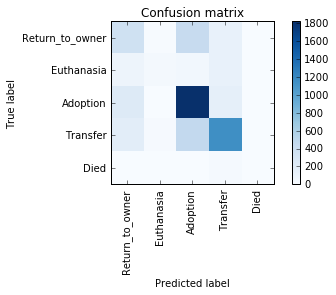

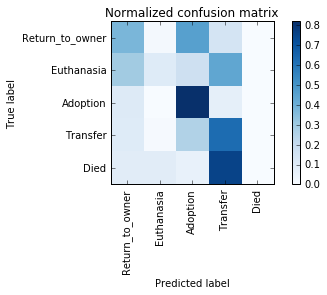

In [74]:
# y_train = np.copy(y)
# y_train[unlabeled_indices] = -1

# lp_model = label_propagation.LabelSpreading(gamma=0.25, max_iter=5)
# lp_model.fit(X, y_train)

# predicted_labels = lp_model.transduction_[unlabeled_indices]
# true_labels = y[unlabeled_indices]

labels = y.unique()


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Print the Classification Report
print(classification_report(y_test, y_test_pred))
    
# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=labels)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

#     print('Iteration %i %s' % (i, 70 * '_'))
#     print("Label Spreading model: %d labeled & %d unlabeled (%d total)"
#           % (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))


# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()


#### Submission into CSV file

In [75]:
X.head(), y.head()

(   AgeOutInWeeks  AnimalType_Cat  AnimalType_Dog  Sex_Female  Sex_Male  \
 0           52.0             0.0             1.0         0.0       1.0   
 1           52.0             1.0             0.0         1.0       0.0   
 2          104.0             0.0             1.0         0.0       1.0   
 3            3.0             1.0             0.0         0.0       1.0   
 4          104.0             0.0             1.0         0.0       1.0   
 
    Sex_Unknown  Neutered_Intact  Neutered_Neutered  Neutered_Unknown  Mix_mix  \
 0          0.0              0.0                1.0               0.0      1.0   
 1          0.0              0.0                1.0               0.0      1.0   
 2          0.0              0.0                1.0               0.0      1.0   
 3          0.0              1.0                0.0               0.0      1.0   
 4          0.0              0.0                1.0               0.0      1.0   
 
    Mix_not  
 0      0.0  
 1      0.0  
 2      0.0 

In [76]:
X.shape, y.shape

((26729, 11), (26729,))

In [77]:
# retrain with the complete training set
dt.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            presort=False, random_state=99, splitter='best')

In [87]:
len(X_test_submit)

11456

In [88]:
y_pred = dt.predict(X_test_submit)

In [89]:
y_pred_proba = dt.predict_proba(X_test_submit)

In [91]:
y_pred_proba

array([[ 0.67,  0.  ,  0.01,  0.12,  0.2 ],
       [ 0.54,  0.  ,  0.02,  0.26,  0.18],
       [ 0.39,  0.  ,  0.02,  0.1 ,  0.49],
       ..., 
       [ 0.39,  0.  ,  0.02,  0.1 ,  0.49],
       [ 0.38,  0.  ,  0.04,  0.42,  0.16],
       [ 0.23,  0.  ,  0.06,  0.51,  0.2 ]])

In [90]:
results = pd.read_csv("sample_submission.csv")

In [92]:
results.head()

ID  Adoption  Died  Euthanasia  Return_to_owner  Transfer
0   1         1     0           0                0         0
1   2         1     0           0                0         0
2   3         1     0           0                0         0
3   4         1     0           0                0         0
4   5         1     0           0                0         0

In [93]:
results['Adoption'], results['Died'], results['Euthanasia'], results['Return_to_owner'], results['Transfer'] \
= y_pred_proba[:,0], y_pred_proba[:,1], y_pred_proba[:,2], y_pred_proba[:,3], y_pred_proba[:,4]

In [94]:
#Submission File
results.to_csv("DT_submission.csv", index=False)

In [ ]:

# X = kobe[['shot_distance','minutes_remaining']]
# y = kobe['shot_made_flag']
# #from sklearn.svm import LinearSVC
# clf = LinearSVC()
# clf.fit(X, y)
# kobe['pred'] = clf.predict(X)
# # scatter plot that includes the regression line
# plt.figure(figsize=(15,3))
# plt.scatter(kobe.shot_distance, kobe.shot_made_flag)
# plt.scatter(kobe.shot_distance, kobe.pred, color='red', alpha=0.1)
# plt.xlabel('shot_distance')
# plt.ylabel('shot_made_flag')

# from sklearn.metrics import accuracy_score
# accuracy_score(kobe.shot_made_flag, kobe.pred.round())

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=500, n_jobs=4)
forest.fit(X_train, y_train)

In [ ]:
y_pred_val = forest.predict(X_val)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_val, y_pred_val))
print("Accuracy: %1.3f" % accuracy_score(y_val, y_pred_val))


#### Try Random Forest Model

In [ ]:
# Use scikitlearn to build a Random Forest model
# from sklearn.model_selection import train_test_split
# X_train, X_val, y_train, y_val = train_test_split(train, train_outcome, test_size=0.15)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=500, n_jobs=4)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [97]:
y_train_pred = forest.predict(X_train)
y_train_proba = forest.predict_proba(X_train)

In [98]:
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_train, y_train_pred))
print("Accuracy: %1.3f" % accuracy_score(y_train, y_train_pred))

             precision    recall  f1-score   support

   Adoption       0.65      0.82      0.73      8550
       Died       0.83      0.03      0.06       164
 Euthanasia       0.62      0.10      0.17      1257
Return_to_owner       0.46      0.45      0.46      3825
   Transfer       0.74      0.65      0.69      7587

avg / total       0.65      0.65      0.63     21383

Accuracy: 0.646


In [99]:
scores_train = cross_validation.cross_val_score(forest, ecode_X_train, y_train, cv=10)
scores_train

array([ 0.63,  0.63,  0.63,  0.63,  0.63,  0.63,  0.63,  0.64,  0.63,  0.62])

In [104]:
y_test_pred = forest.predict(X_test_submit)
y_test_proba = forest.predict_proba(X_test_submit)

In [101]:
results = pd.read_csv("sample_submission.csv")

In [102]:
results['Adoption'], results['Died'], results['Euthanasia'], results['Return_to_owner'], results['Transfer'] \
= y_pred_proba[:,0], y_pred_proba[:,1], y_pred_proba[:,2], y_pred_proba[:,3], y_pred_proba[:,4]

In [103]:
#Submission File
results.to_csv("RF_submission.csv", index=False)

In [112]:
log_loss(y_train, y_train_proba)

0.84066058838926505

In [ ]:
pd.get_dummies()

#### Try Boosting Classifier Model (AdaBoostClassifier)

In [ ]:
# build a classifier with scikit-learn

import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

A1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2),
                        n_estimators = 100,
                        learning_rate = 0.1)

classifiers = [c.fit(_train_df.values[:,1:-1] , _train_df.values[:,-1].astype(int)) for c in [A1]]
results = [c.predict_proba(_validation_df.values[:,1:-1]) for c in classifiers]
print(results[0])